In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
import tensorflow as  tf
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from collections import Counter
import xgboost as xgb
import pymatgen.core as mg
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

# In this we use dataset of HEA and elemental properties to create a dataset


In [11]:
df = pd.read_csv('10387_2_noP.csv', encoding="iso-8859-1")
NAME_HEAs = list (df['Alloy'])

#%% creating an empty dataframe with columns of elements and row of alloys
element_symbols = ['Num_el','H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
                   'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
                   'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                   'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
                   'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
                   'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
                   'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
                   'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
                   'Tl', 'Pb', 'Bi', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm',
                   'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg',
                   'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv',
                   'Ts', 'Og']

# Create an empty dataframe with columns named after element symbols
df2 = pd.DataFrame(columns=element_symbols)
print('Creating an Empty dataframe')
for s in tqdm(range (len(NAME_HEAs))):
    df2.loc[s] = [0]*len(element_symbols)
    
    
df2.index = NAME_HEAs

#%% to fill the above data frame
print('filling the dataframe regarding the composition of alloys')
i = 0
for name in tqdm(NAME_HEAs):
    # print(name)
    
    HEAs = mg.Composition(name)
    sym = []
    frac = []
    
    for i in range (len(HEAs)):
        el = HEAs.elements[i].symbol
        el_frac = HEAs.get_atomic_fraction(el)
        sym.append(el)
        frac.append(el_frac)
    
    for j in range (len(sym)):
        df2.loc[name, 'Num_el'] = len(sym)
        df2.loc[name, sym[j]] = frac[j] 
#%%
cols_with_all_zeros = df2.columns[(df2 == 0).all()] #delete columns with zero values
df2 = df2.drop(cols_with_all_zeros, axis=1)
df2 = df2.iloc[:, :-5] #delete columns with none values
#%%
class Read_prepare_data:
    def __init__(self, name='elemental_propertieses2.csv'):
        self.df = pd.read_csv(name)
        # self.df.drop('Unnamed: 0',inplace=True, axis=1)
        # self.df.sort_values(by=['atomic_number'], ascending=True, inplace=True, ignore_index=True)
        self.df.set_index('symbol', inplace=True)
    def list_att(self):
        return self.df.columns.tolist()

    def keep_att(self, list_keep): #When the number of attributes or discroptors is huge we just keep some of them
        self.df = self.df[list_keep]
        return  self.df.dropna()
    
    def drop_att(self, list_drop):
        
        for i in list_drop:
            self.df.drop(i, inplace=True, axis=1)
            
        return self.df
        
#%%
obj = Read_prepare_data()
att = obj.list_att()
my_choice2 = ['VEC', 'Pauling_EN', 'Melting_point_K','DFT_LDA_Etot', 
'outer_shell_electrons', 'no_of_valence_electrons',
              'Atomic_radius_calculated', 'Atomic_weight']
df_element_attribute = obj.keep_att(my_choice2)
#%%
corr_matrix = df_element_attribute.corr()

#%%
class Mixture:
    def __init__(self, name, ATT, df):
        self.HEAs = mg.Composition(name)
        self.sym = []
        self.frac = []
        self.df = df
        self.ATT = ATT
    
        for i in range (len(self.HEAs)):
            self.el1 = self.HEAs.elements[i].symbol
            self.el1_frac = self.HEAs.get_atomic_fraction(self.el1)
            
            self.sym.append(self.el1)
            self.frac.append(self.el1_frac)
            
        self.b = []
        for m in self.sym:
            self.condition = self.df.index == m
            self.indices = self.df.index[self.condition]
            self.var = self.df.loc[self.indices, self.ATT]
            self.var2 = pd.Series.to_numpy(self.var)
            self.var2 = self.var2[0]
            
            self.b.append(self.var2)
         
    def mix(self):
        self.b = np.array(self.b)
        self.frac = np.array(self.frac)
        
        self.final = np.dot(self.b, self.frac)
        return self.final
#%%
att_name = list(df_element_attribute.columns)
#%%
print("Applying rule of mixture")
whole = []
i=0
for Name in tqdm(NAME_HEAs):
    #print(Name)
    #i=i+1
    #print(i)
    
    for at in att_name:
        ex = Mixture(Name, at, df_element_attribute)
        tmp = ex.mix()
        whole.append(tmp)
whole = np.reshape(whole, (len(NAME_HEAs), len(att_name)))
data = pd.DataFrame(whole, index = NAME_HEAs, columns=att_name)

#%%
#sqrt(sigma(i-ave)**2)
lst_difs = ['Pauling_EN']

for ii, lst_dif in enumerate(lst_difs):
    ind = list(data.index)
    dif_lst = []
    for iterator in ind:
        
        av = data.loc[iterator, lst_dif]
        if isinstance(av, pd.core.series.Series):
            av = av.iloc[0]
        sum_power_two_mul_frac = 0
        com = mg.Composition(iterator)
        for el in range (len(com)):
            symb = com.elements[el].symbol
            fra  = com.get_atomic_fraction(symb) 
            i_th_att = df_element_attribute.loc[symb, lst_dif]
            power_two = (i_th_att-av)**2
            power_two_mul_frac = fra * power_two
            sum_power_two_mul_frac+= power_two_mul_frac
            
        final = np.sqrt(sum_power_two_mul_frac)
        dif_lst.append(final)
        
    
    data[lst_dif+'_div'] = dif_lst


#%% Entropy
ind = list(data.index)
entropy = 0
entropy_list = []
for iterator in ind:
    com = mg.Composition(iterator)
    entropy = 0
    for el in range (len(com)):
        symb = com.elements[el].symbol
        fra  = com.get_atomic_fraction(symb) 
        entropy += -8.314*fra * ((np.log(fra)))
    entropy_list.append(entropy)


data['entropy'] = entropy_list

#%%
#sqrt(sigma(1-i/ave)**2)
lst_difs = ['Atomic_radius_calculated']

for ii, lst_dif in enumerate(lst_difs):
    ind = list(data.index)
    dif_lst = []
    for iterator in ind:
        
        av = data.loc[iterator, lst_dif]
        if isinstance(av, pd.core.series.Series):
            av = av.iloc[0]
        sum_power_two_mul_frac = 0
        com = mg.Composition(iterator)
        for el in range (len(com)):
            symb = com.elements[el].symbol
            fra  = com.get_atomic_fraction(symb) 
            i_th_att = df_element_attribute.loc[symb, lst_dif]
            power_two = (1.0-i_th_att/av)**2
            power_two_mul_frac = fra * power_two
            sum_power_two_mul_frac+= power_two_mul_frac
            
        final = np.sqrt(sum_power_two_mul_frac)
        dif_lst.append(final)
        
    
    data[lst_dif+'_dif'] = dif_lst


#%% mixing enthalpy 4Hcicj
ind = list(data.index)

df_enthalpy = pd.read_csv('Enthalpy_mix.csv')
df_enthalpy.set_index('symbol', inplace=True)
df_enthalpy.drop('H',inplace=True, axis=1)

mix_enthalpy = []
for iterator in ind:
    #print(iterator)
    com = mg.Composition(iterator)

    symb = []
    frac = []
    for i in range (len(com)):
        sym = com.elements[i].symbol
        # el1_frac = com.get_atomic_fraction(sym)
        symb.append(sym)
        # frac.append(el1_frac)
    agg = 0

    for k in symb:
        for n in symb:
            if k==n: 
                continue
            else:
                mix = df_enthalpy.loc[k,n]
                k_frac = com.get_atomic_fraction(k)
                n_frac = com.get_atomic_fraction(n)
                agg += mix * k_frac * n_frac
                
    mix_enthalpy.append(2*agg)



data['Enthalpy'] = mix_enthalpy
#%%

df_concatenated = pd.concat([df2, data], axis=1)
#%%

y = df["Phase"].copy()
y = y.to_frame()
data_rest = df_concatenated.reset_index()
data_rest['Geo'] = data_rest['entropy'] / (data_rest['Atomic_radius_calculated_dif'])**2
data_final = pd.concat([data_rest, y], axis=1)
data_final['Atomic_radius_calculated_dif'] = data_final['Atomic_radius_calculated_dif']*100
data_final['E_per_el'] = data_final['DFT_LDA_Etot']/data_final['Num_el']
#data_final['Omega'] = data_final['Melting_point_K'] * data_final['entropy'] / abs(data_final['Enthalpy'])

Creating an Empty dataframe


100%|███████████████████████████████████████████████████████████████████████████| 10387/10387 [00:29<00:00, 352.10it/s]


filling the dataframe regarding the composition of alloys


100%|███████████████████████████████████████████████████████████████████████████| 10387/10387 [00:38<00:00, 266.98it/s]


Applying rule of mixture


100%|████████████████████████████████████████████████████████████████████████████| 10387/10387 [02:48<00:00, 61.51it/s]


# Droping Duplicate

In [49]:
data = data_final
df = data.iloc[:, :-3].join(data.iloc[:, -1:].join(data.iloc[:, -2:-1]))
df.drop_duplicates(keep='first', inplace=True) # droping duplicates

In [50]:
df.shape

(7590, 69)

# Droping data with inconsistant reports of phase

In [51]:
duplicates = df[df.iloc[:, :-1].duplicated(keep=False)]
grouped = duplicates.groupby(list(duplicates.iloc[:, :-1].columns))
mask = grouped['Phase'].nunique() > 1
indices_to_drop = mask[mask].index
df.drop(df.index[df.iloc[:, :-1].apply(tuple, axis=1).isin(indices_to_drop)], inplace=True)

output = df['Phase'].to_frame()
df.drop(df.columns[-1], axis=1, inplace=True) # drop phase
df['Omega'] = df['Melting_point_K'] * df['entropy'] / abs(df['Enthalpy'])
df = pd.concat([df, output], axis=1)

# Composition plot


# Anomoly detection

In [52]:
df = df.iloc[:,-15:]
df['Geo'] = df['entropy'] / (df['Atomic_radius_calculated_dif'])**2

In [53]:
df = df.drop('Geo', axis=1)
df = df.drop('Omega', axis=1)

In [54]:
output = df['Phase'].to_frame()
cat_list = output.index.tolist()
cat_num =  df['Phase'].value_counts()
#%%
def remove_outliers(data):
    data_encoded = pd.get_dummies(data, columns=['Phase'])

    model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
    # Fit the model to the data
    model.fit(data_encoded)
    
    # Predict the outliers
    outliers = model.predict(data_encoded)
    
    # Filter the outliers from the original dataset
    data_filtered = data[~(outliers == -1)]
    cat_vars = ['Phase']
    filtered_cat_vars = data_filtered[cat_vars]
    filtered_data = pd.concat([data_filtered.drop(cat_vars, axis=1), filtered_cat_vars], axis=1)
    return filtered_data

BCC = df[df['Phase'] == 'BCC']
FCC = df[df['Phase'] == 'FCC']
FCC_BCC =  df[df['Phase'] == 'BCC+FCC']

BCC_IM = df[df['Phase'] == 'BCC+IM']
FCC_IM = df[df['Phase'] == 'FCC+IM']
FCC_BCC_IM =  df[df['Phase'] == 'BCC+FCC+IM']
IM =  df[df['Phase'] == 'IM']

AM =  df[df['Phase'] == 'AM']
BCC_AM =  df[df['Phase'] == 'BCC+AM']
FCC_AM =  df[df['Phase'] == 'FCC+AM']
FCC_BCC_AM =  df[df['Phase'] == 'BCC+FCC+AM']

dfs = [BCC, FCC, FCC_BCC, BCC_IM, FCC_IM, FCC_BCC_IM,IM, AM, BCC_AM,FCC_AM , FCC_BCC_AM ]

new_df = []
for dd in tqdm(dfs):
    dd = remove_outliers(dd)
    new_df.append(dd)
df = pd.concat(new_df, axis=0, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]


In [55]:
df.shape

(5677, 14)

# Plotting anamoly detection

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})

def plt_vec_size(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    categories = df['Phase']
    
    # define a color map for the categories
    colors = {'FCC': 'r', 'BCC': 'g', 'BCC+FCC': 'b'}
    color_list = [colors[cat] for cat in categories]
    
    plt.scatter(x = df['VEC'], y=df['Pauling_EN'], c =color_list)
    # ax.scatter(x = df['VEC'], y=df['Atomic_radius_calculated_dif'], c =color_list)
    
    
    handles = [plt.plot([],[], marker="o", ls="", color=color, label=label)[0] 
               for label, color in colors.items()]
    plt.legend(handles=handles, title='Categories', loc='lower right')
    
    
    plt.xlabel('VEC')
    plt.ylabel((r'$Electronegativity$'))
    fig.savefig('Pauling_EN(FCC&BCC)_NOaut.jpg', dpi=600)


BCC = df[df['Phase'] == 'BCC']
BCC_ = BCC.describe()
FCC = df[df['Phase'] == 'FCC']
FCC_ = FCC.describe()
FCC_BCC =  df[df['Phase'] == 'BCC+FCC']
FCC_BCC_= FCC_BCC.describe()

dfs = [BCC, FCC, FCC_BCC]
df = pd.concat(dfs, axis=0, ignore_index=True)

plt_vec_size(df)

In [48]:
df.shape

(4025, 14)

# Preprocessing

In [56]:
def normalization (df_in, method='std',  bb=0, ee=13):
    
    need_scale = df_in.columns[bb:ee]
    #need_scale = df_in.columns[26:35]
    
    # here we need to selcet which type of standardization wee need
    if method == 'std':
        scaler = StandardScaler()
    else: 
        scaler = MinMaxScaler()
    
    cols_to_norm = need_scale
    df_in[cols_to_norm] = scaler.fit_transform(df_in[cols_to_norm])
    return df_in

def input_output(df, output_name= 'Phase', cat_name = 'process'):
    # cat_encoder = OneHotEncoder()
    ordinal_encoder = OrdinalEncoder()
    df_out = ordinal_encoder.fit_transform(df[[output_name]])
    df_out = df_out.ravel()
    df_in = df.drop(output_name, axis=1)
    # df_in = df_in.drop('Alloy ', axis=1)
    # df_encoded = pd.get_dummies(df_in[cat_name], prefix=cat_name)
    # df_in = pd.concat([df_in.drop(cat_name, axis=1), df_encoded], axis=1)
    return df_in, df_out
def split(df_in, df_out, test_size = 0.1 ):
    X_train, X_test, y_train, y_test = train_test_split(df_in, df_out, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test
def RF_train(X_train, y_train,n_estimators ):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    print('Begining of fitting')
    model.fit(X_train, y_train)
    print('End of fitting')
    return model

# Normalization

In [57]:
df = normalization(df)

# Train-test split and data augmentation

In [59]:
output = df['Phase'].to_frame()
df.drop(df.columns[-1], axis=1, inplace=True)
X_train, X_test, y_train, y_test =  split(df, output)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
cat_num =  y_train['Phase'].value_counts()
cat_num2 =  y_resampled['Phase'].value_counts()

## ploting data augmentation


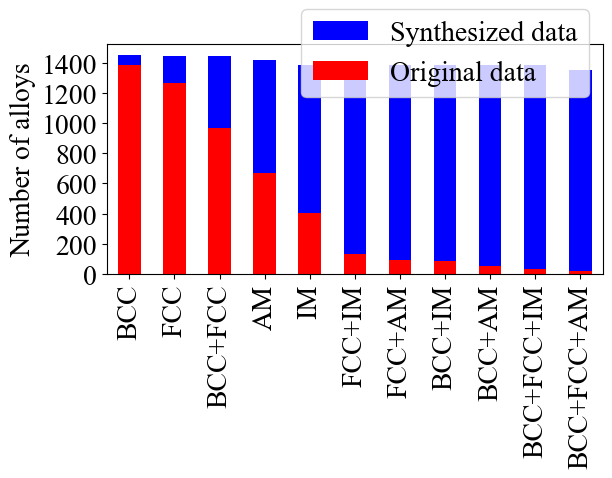

<Figure size 640x480 with 0 Axes>

In [62]:
plt.figure()
ax = cat_num2.plot.bar(color='blue', label='Synthesized data')
cat_num.plot.bar(color='red', label='Original data', ax=ax)
plt.subplots_adjust(bottom=0.4)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.21))
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 9})
plt.ylabel("Number of alloys")
plt.show()
plt.savefig('Cat_caunt.jpg', dpi=600, bbox_inches='tight')

In [65]:
print(y_train)

        Phase
2609      FCC
2656      FCC
5317       AM
2669      FCC
3317  BCC+FCC
...       ...
3772  BCC+FCC
5191       AM
5226       AM
5390       AM
860       BCC

[5109 rows x 1 columns]


In [66]:
print(X_train)

           VEC  Pauling_EN  Melting_point_K  DFT_LDA_Etot  \
2609  1.334290    1.076953        -0.703296     -0.413807   
2656  0.999670    0.599466         0.540295     -0.400076   
5317  0.483336   -0.301745         0.421739     -0.193751   
2669  1.085940    0.803637        -0.949171     -0.269328   
3317 -0.210141    0.191323         0.317350      0.317529   
...        ...         ...              ...           ...   
3772  0.658940    0.836816        -0.977970     -0.014281   
5191  0.806458    0.710303         0.839562     -0.307000   
5226  0.793203    0.419071         0.518954     -0.308426   
5390  0.353906   -0.683797         0.287848     -0.143006   
860  -1.034954   -0.707191        -1.163477      0.887816   

      outer_shell_electrons  no_of_valence_electrons  \
2609              -1.026410                 1.310560   
2656              -0.953767                 0.975536   
5317              -0.922044                 0.458579   
2669              -1.203996                